# 单细胞scRNA-seq数据分析-数据可视化

In [1]:
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

%config InlineBackend.figure_format = 'retina'

## Data Loading

In [2]:
adata = sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
## randomly assign the cells to three pseudo-sample
import numpy.random as random
rand_numbers = random.choice([1,2,3], size=adata.shape[0])
adata.obs['patient'] = rand_numbers
adata.obs['patient'] = adata.obs['patient'].map({1:'P1', 2:'P2', 3:'P3'})

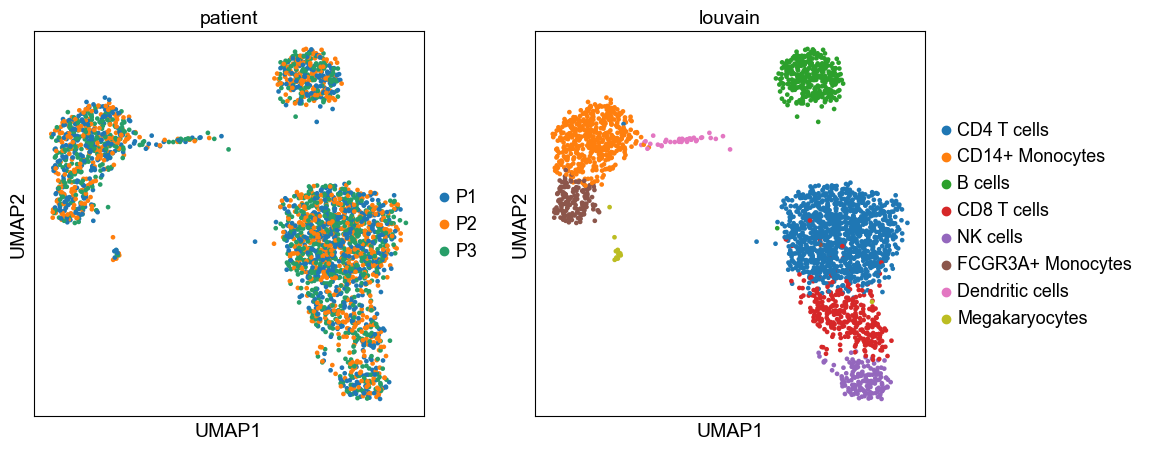

In [6]:
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(5, 5))
sc.pl.umap(adata, color=['patient', 'louvain'], save='.cluster.pdf')

## Visualization

####  embeddings

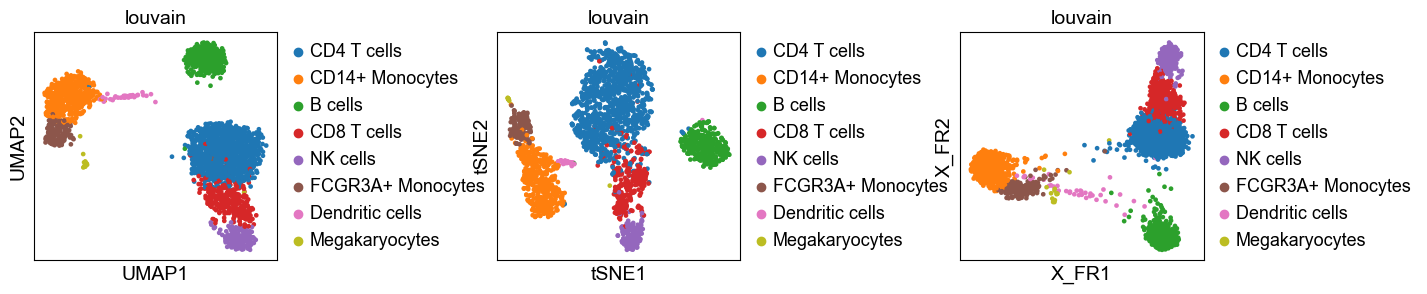

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sc.pl.umap(adata, color='louvain', ax=axes[0], show=False)
sc.pl.tsne(adata, color='louvain', ax=axes[1], show=False)
sc.pl.embedding(adata, basis='X_draw_graph_fr',color='louvain', ax=axes[2], show=False)
plt.subplots_adjust(wspace=.9)
plt.savefig('./figures/embbeding.pdf', dpi=300)

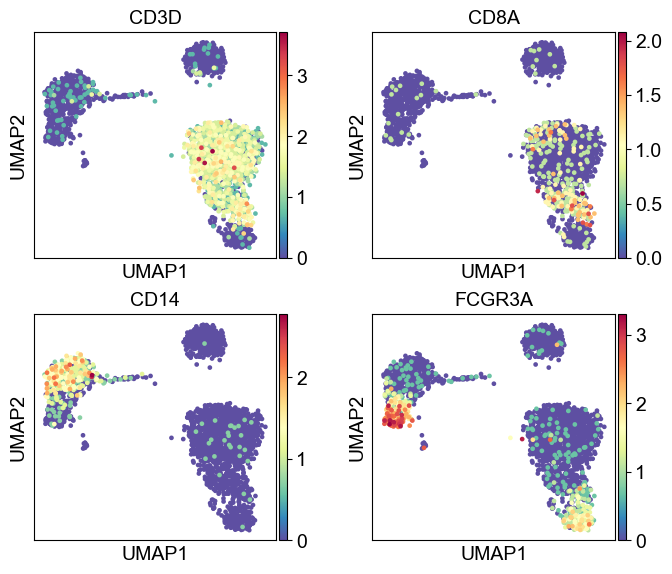

In [9]:
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(3, 3.1))
sc.pl.umap(adata, color=['CD3D', 'CD8A', 'CD14', 'FCGR3A'], ncols=2, cmap='Spectral_r')

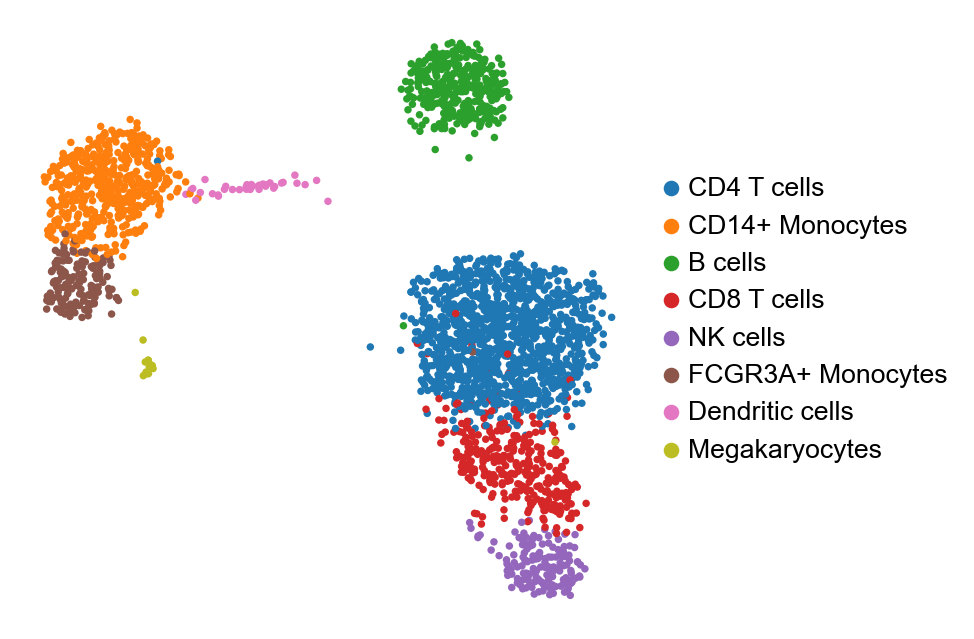

In [12]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, figsize=(5,5))
sc.pl.umap(adata, color='louvain', frameon=False, title='',
           legend_loc='right margin', legend_fontsize=12,
           legend_fontweight='normal', legend_fontoutline=6,
           palette=None, cmap=None, save='.clusters.pdf'
          )
###  to explain the legend oder
###  to explain the storage of palette

In [15]:
adata.obs.louvain

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD8 T cells', 'B cells', 'NK cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [14]:
original_order = ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells',
                  'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

adata.obs['louvain'] = adata.obs.louvain.cat.set_categories([
    'CD4 T cells', 'CD8 T cells', 'B cells','NK cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes',
    'Dendritic cells', 'Megakaryocytes'
])

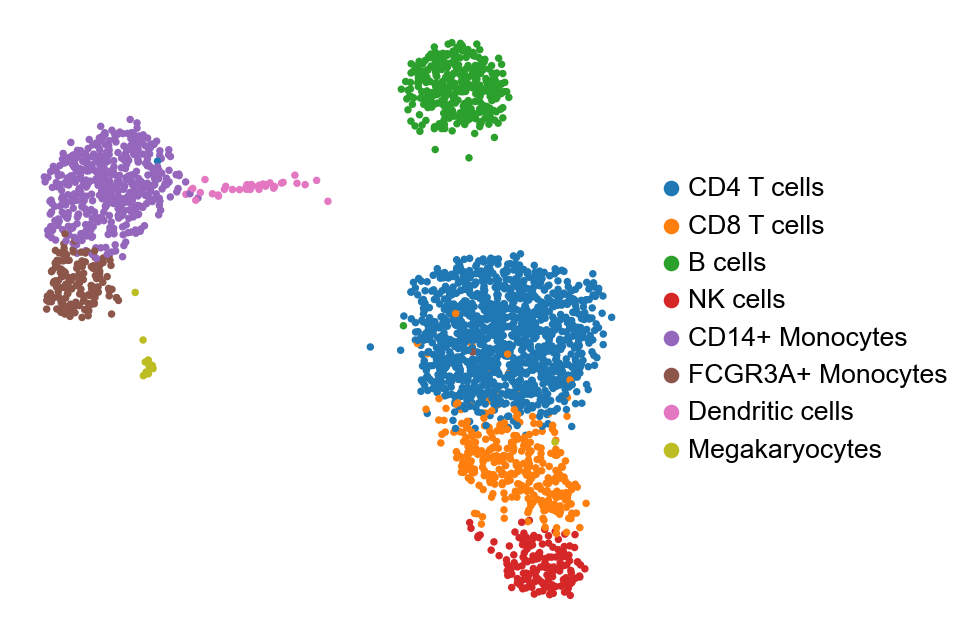

In [16]:
sc.pl.umap(adata, color='louvain', frameon=False, title='',
           legend_loc='right margin', legend_fontsize=12,
           legend_fontweight='normal', legend_fontoutline=6,
           palette=None, cmap=None, save='.clusters.pdf'
          )

In [17]:
adata.obs['louvain'] = adata.obs.louvain.cat.set_categories(original_order)

#### stacked barplot

In [19]:
def draw_population_ratio(df:pd.DataFrame, x:str, y:str,
                          * ,data_colors:dict=None,
                          normalize=True,
                          path=None,
                          legend=True,
                          figsize=(6, 3)):
    df = df[[x, y]]
    x_items = df[x].cat.categories.tolist()
    y_items = df[y].cat.categories.tolist()
    y_dict = df[y].value_counts().to_dict()
    
    heights = []
    for x_item in x_items:
        tmp_result = []
        x_item_counter = df[df[x]==x_item][y].value_counts().to_dict()
        for y_item in y_items:
            tmp_result.append(x_item_counter.get(y_item, 0))
        heights.append(tmp_result)
    heights = np.asarray(heights)
    if normalize:
        heights = heights/np.sum(heights, axis=0)
    heights = (heights.T/np.sum(heights, axis=1)).T
    plt.figure(figsize=figsize)
    _last = np.matrix([0.]* heights.shape[0])
    for i, y_item in enumerate(y_items):
        p = plt.bar(range(0, heights.shape[0]), heights[:, i],
                    bottom=np.asarray(_last)[0],
                    color=data_colors.get(y_item, 'b'),
                    label=y_item
                   )
        _last = _last + np.matrix(heights[:, i])
    plt.xticks(range(0, len(x_items)),labels=x_items, rotation=70)
    plt.ylim((0, 1))
    if legend:
        plt.legend()
        ax = plt.gca()
        ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 1))
    if path is not None:
        plt.savefig(path, dpi=300)

In [20]:
adata.obs['patient'] = adata.obs.patient.astype('category')

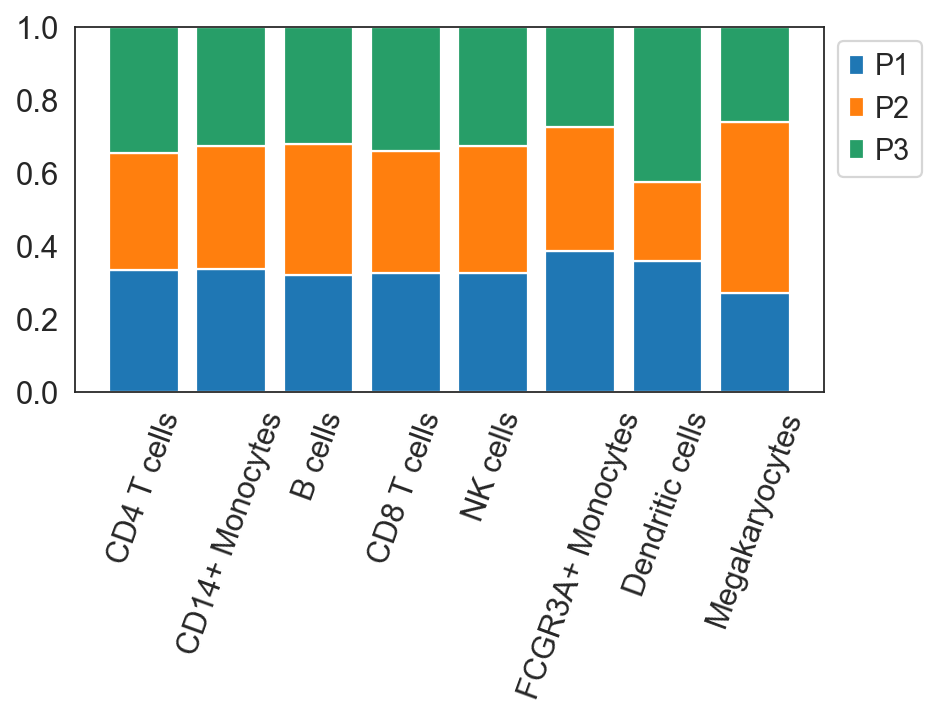

In [21]:
sns.set_style('white')
draw_population_ratio(adata.obs, x='louvain', y='patient',
                      data_colors=dict(zip(adata.obs.patient.cat.categories, adata.uns['patient_colors']))
                     )

#### dotplot

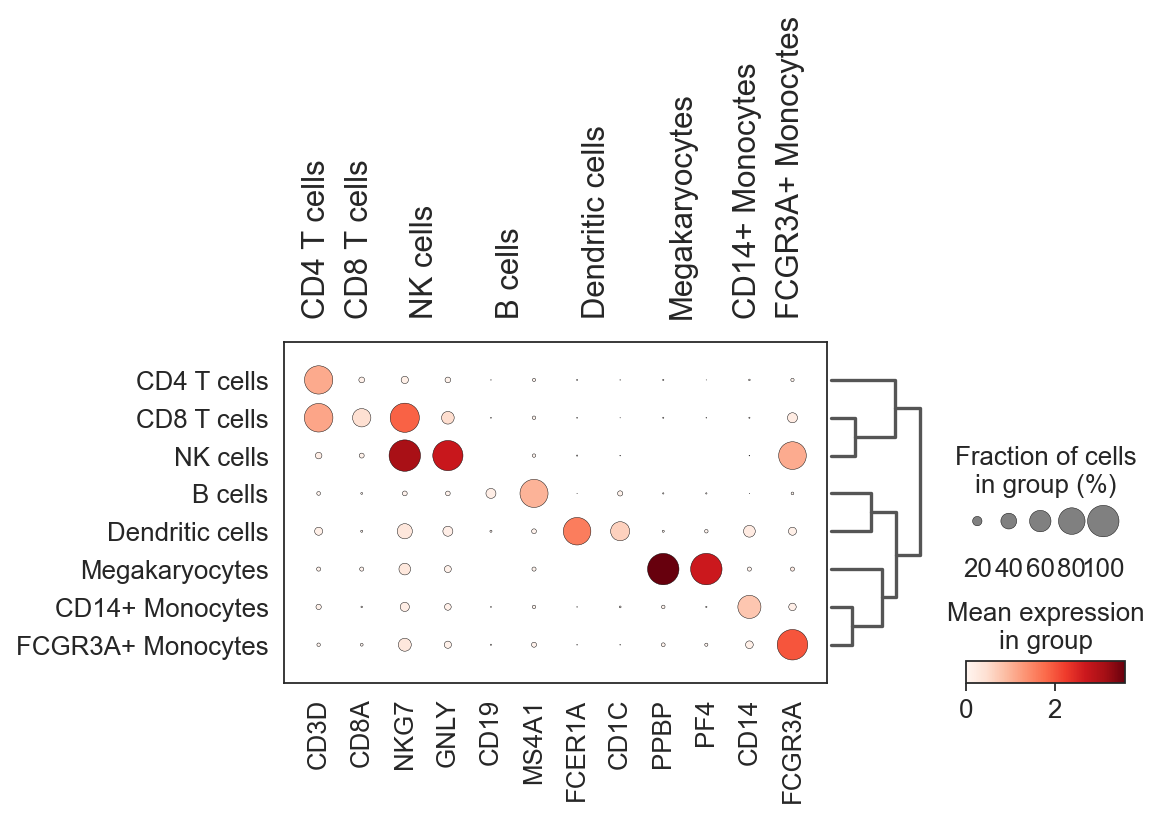

In [25]:
marker_genes_dict = {
    'CD4 T cells':['CD3D'],
    'CD14+ Monocytes':['CD14'],
    'B cells':['CD19', 'MS4A1'],
    'CD8 T cells':['CD8A'],
    'NK cells':['NKG7','GNLY'],
    'FCGR3A+ Monocytes':'FCGR3A',
    'Dendritic cells':['FCER1A', 'CD1C'],
    'Megakaryocytes':['PPBP', 'PF4']
}

sc.pl.dotplot(adata, marker_genes_dict, 'louvain', dendrogram=True, cmap='Reds')

In [26]:
marker_genes_list = []

for k, v in marker_genes_dict.items():
    if isinstance(v, list):
        marker_genes_list.extend(v)
    else:
        marker_genes_list.append(v)

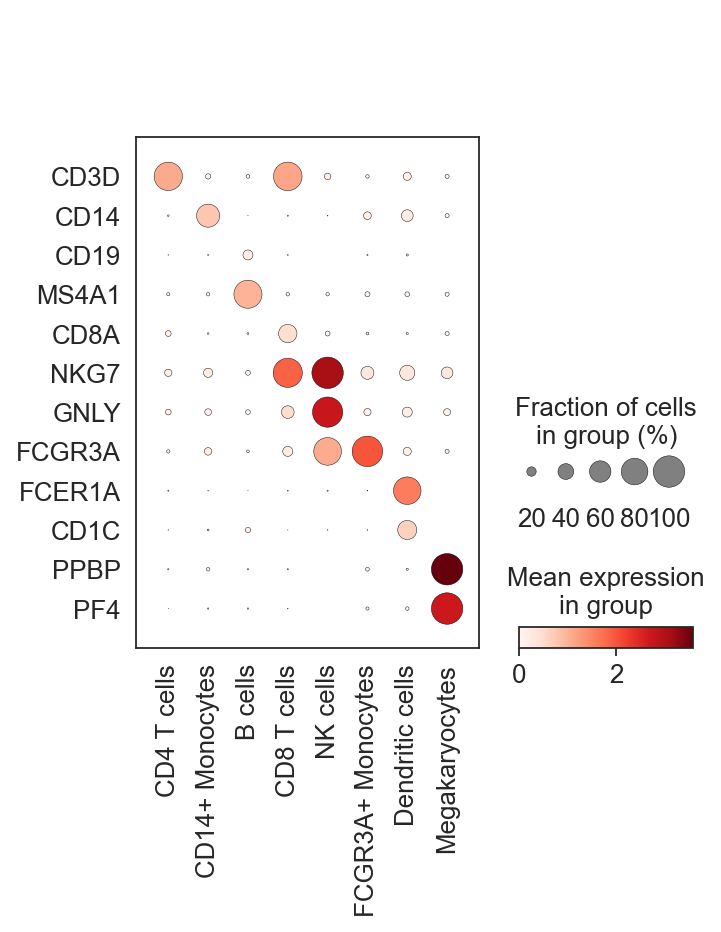

In [28]:
sc.pl.dotplot(adata, marker_genes_list, 'louvain',
              dendrogram=False, cmap='Reds', swap_axes=True)

#### violin plot

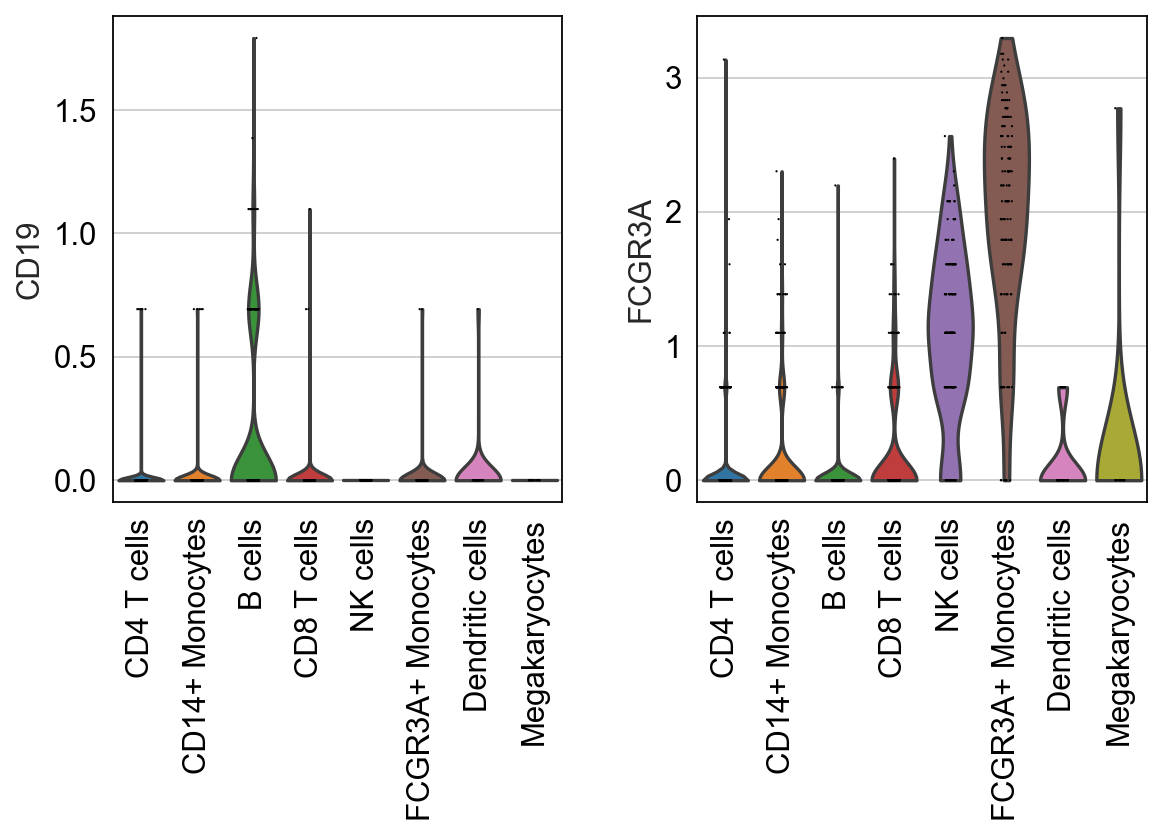

In [34]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, figsize=(4,4))
sc.pl.violin(adata, ['CD19', 'FCGR3A'], groupby='louvain', use_raw=True, rotation=90)

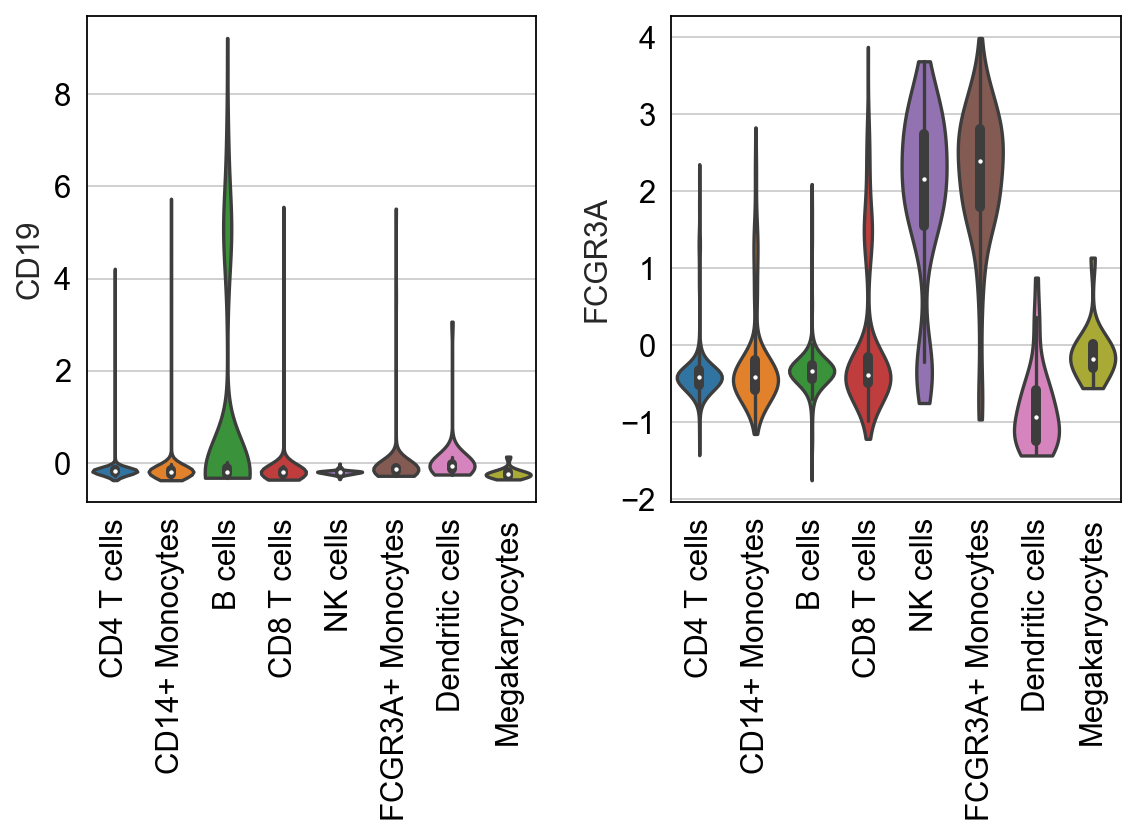

In [35]:
sc.pl.violin(adata, ['CD19', 'FCGR3A'], groupby='louvain',
             stripplot=False, inner='box', use_raw=False, rotation=90)

In [36]:
gene_list = ['CD19','FCGR3A']
df = pd.DataFrame(adata[:, gene_list].X.toarray(), columns=gene_list, index=adata.obs_names.tolist())
df = pd.concat((df, adata.obs[['louvain']]), axis=1)

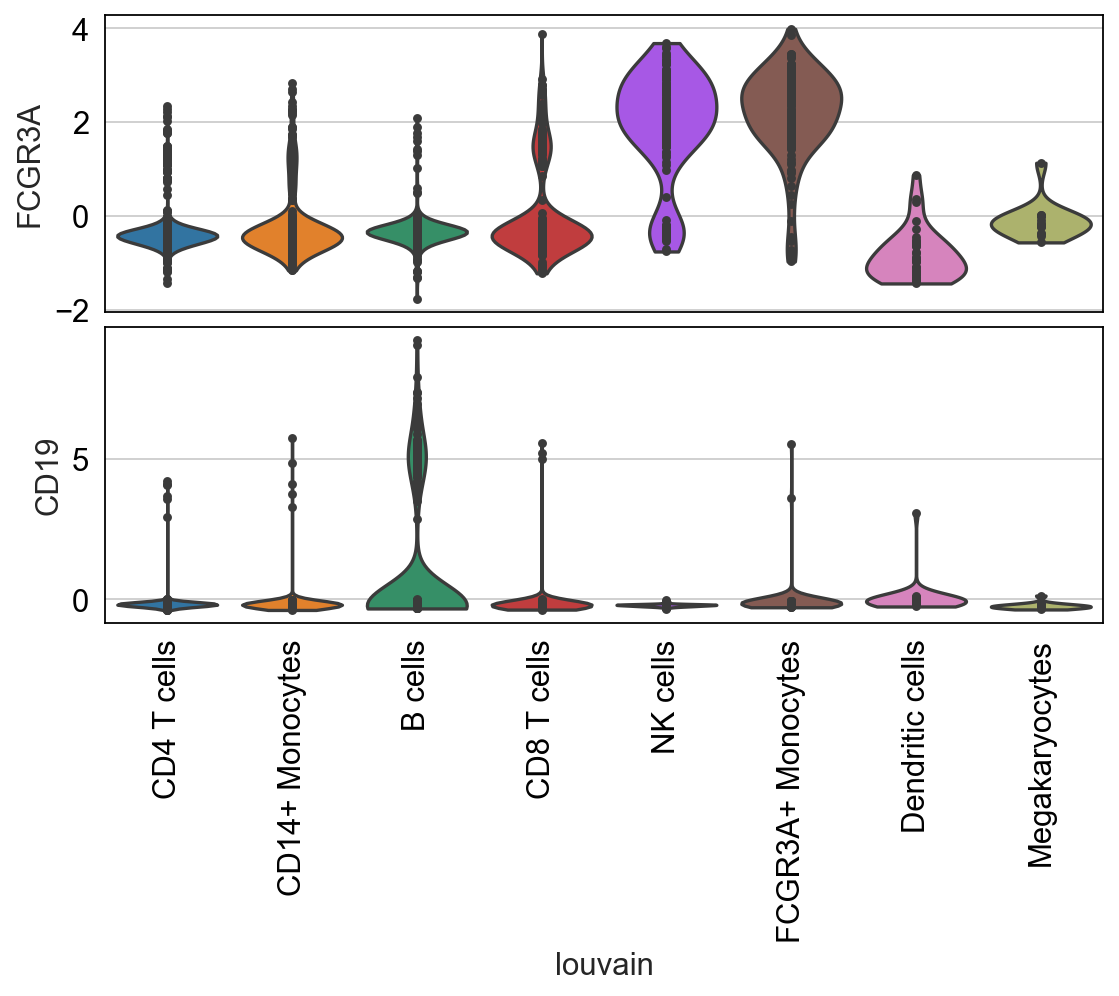

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
sns.violinplot(x='louvain', y='FCGR3A', data=df, ax=axes[0], inner='point', scale='width',cut=0)
sns.violinplot(x='louvain', y='CD19', data=df, ax=axes[1], inner='point', scale='width', cut=0)
_ = axes[0].set_xlabel('')
_ = axes[0].set_xticklabels([])
_ = axes[0].set_xticks([])
_ = axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.subplots_adjust(hspace=0.05)

#### stacked-violin plot

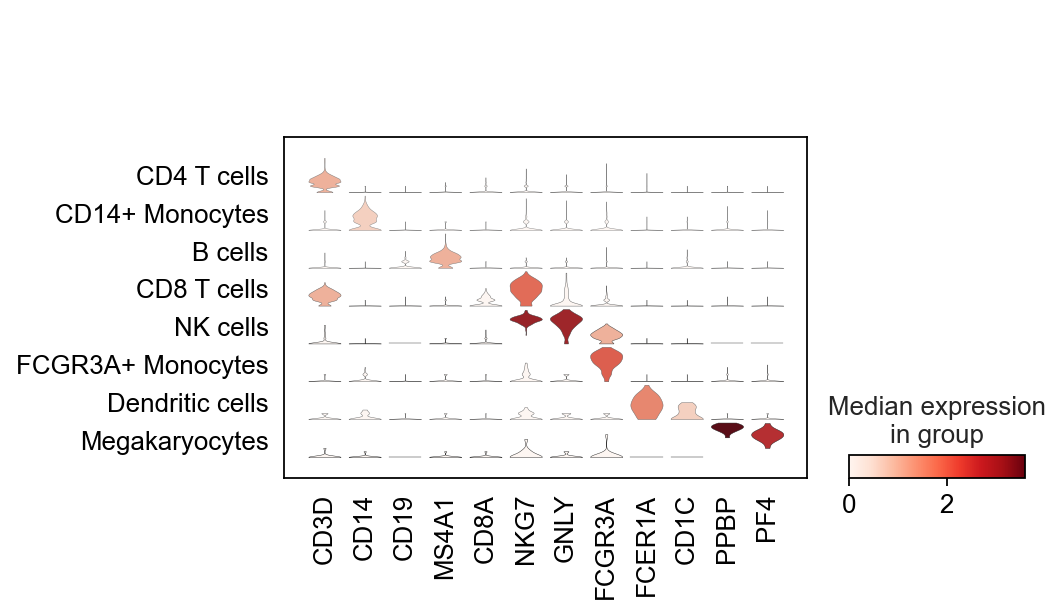

In [41]:
ax = sc.pl.stacked_violin(adata, marker_genes_list,
                          groupby='louvain', swap_axes=False, dendrogram=False, cmap='Reds')

#### matrixplot

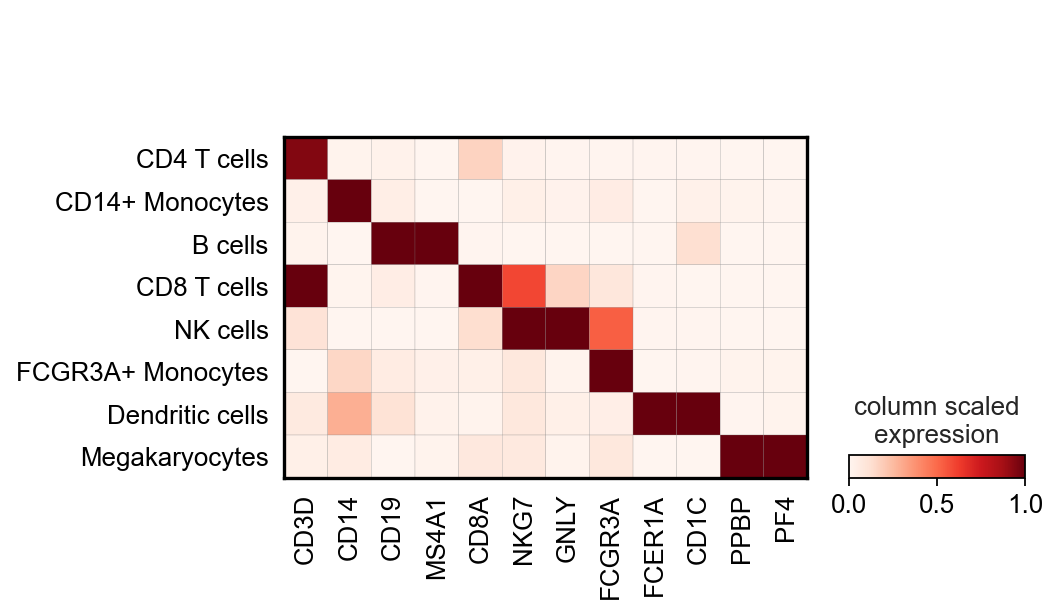

In [43]:
sc.pl.matrixplot(adata, marker_genes_list, 'louvain', dendrogram=False, cmap='Reds',
                 standard_scale='var', colorbar_title='column scaled\nexpression')

#### Heatmaps

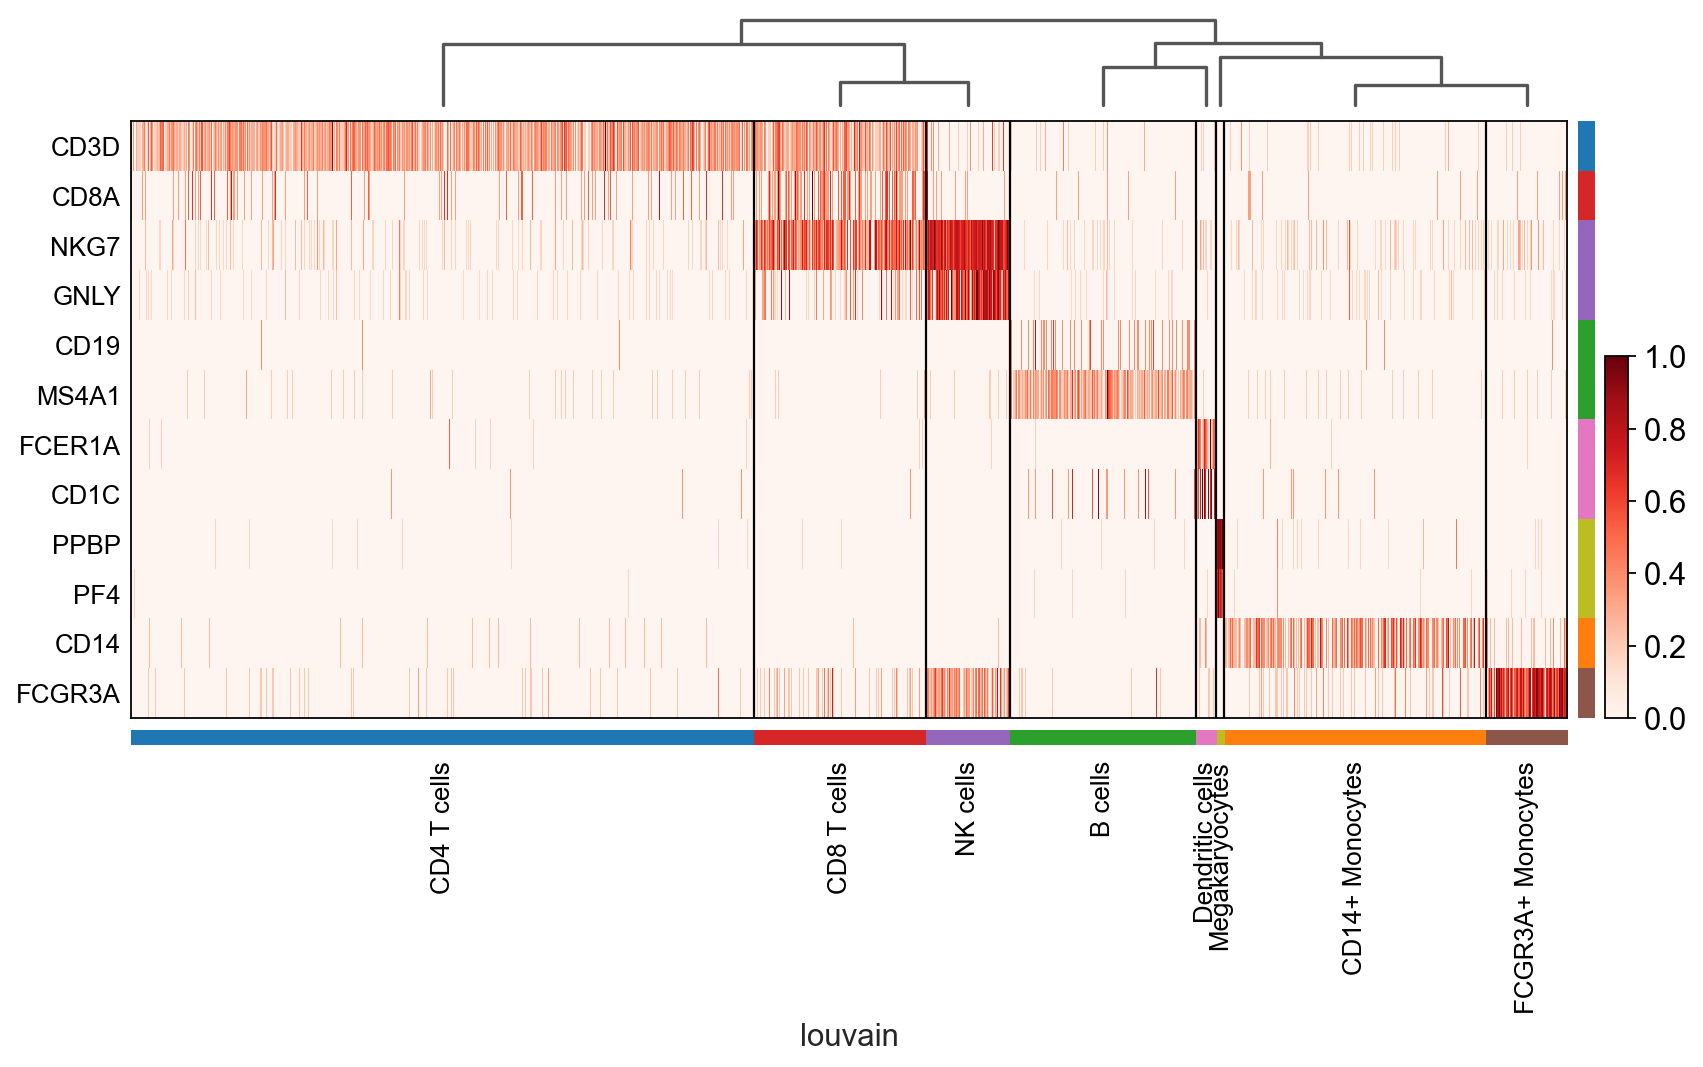

In [47]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='louvain',
                   cmap='Reds', dendrogram=True, standard_scale='var', figsize=(12, 6), swap_axes=True)

####  Heatmaps of mean gene expr

In [56]:
from typing import Optional, Iterable


def grouped_obs_mean(adata:sc.AnnData,
                     group_key:str,
                     var_names:Optional[Iterable]=None,
                     use_raw=True
                    )-> pd.DataFrame:
    if use_raw:
        adata = adata.raw.to_adata()
    if var_names is not None:
        adata = adata[:, var_names]
    getX = lambda x: x.X
    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out


df_gene_expr = grouped_obs_mean(adata, group_key='louvain', var_names=marker_genes_list)

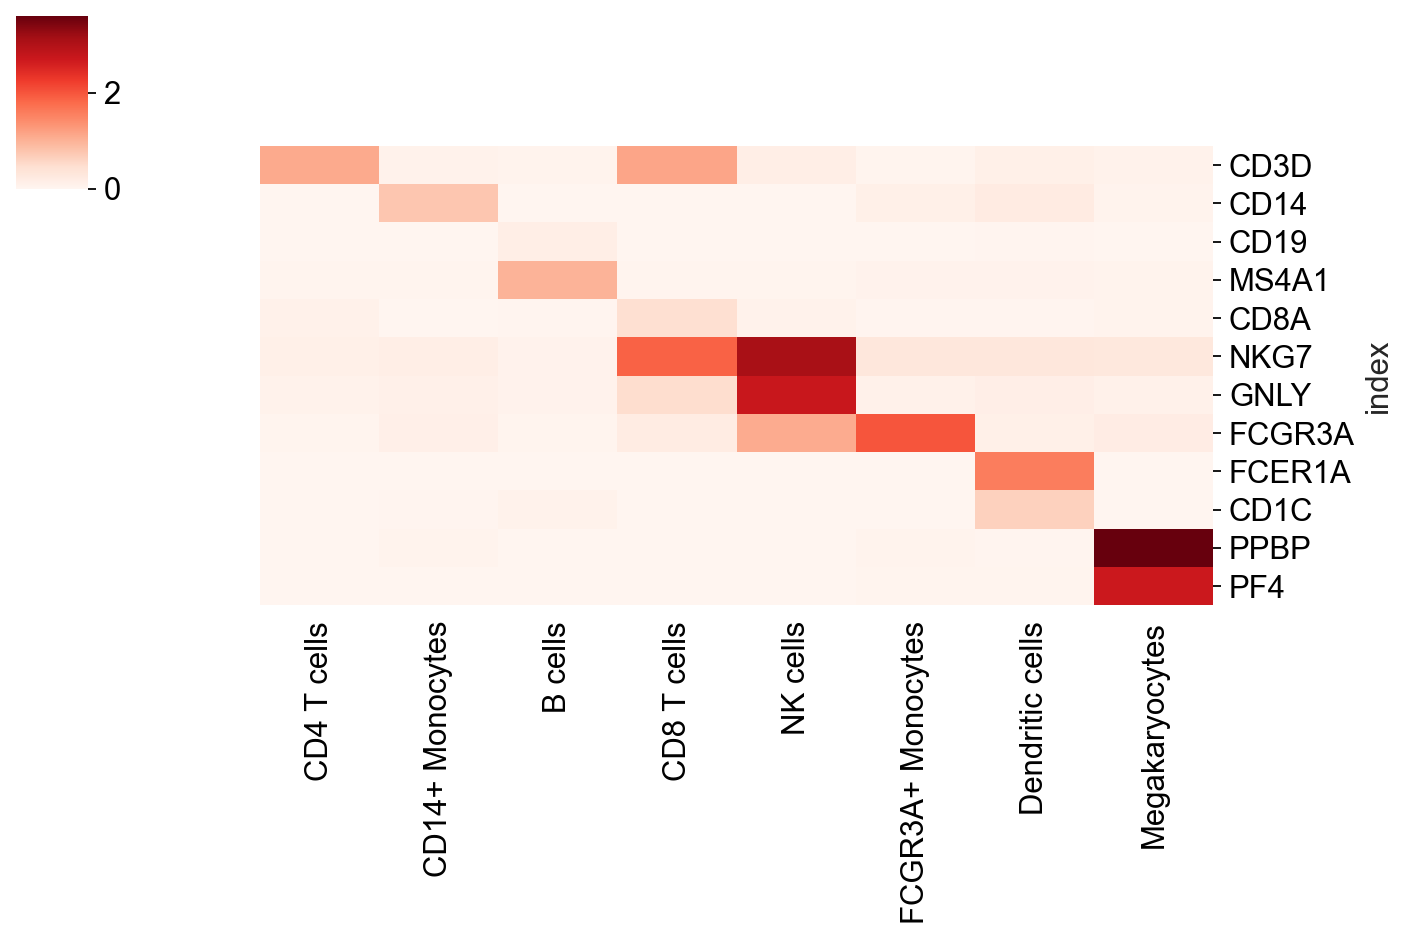

In [59]:
sns.clustermap(df_gene_expr, figsize=(9, 6), cmap='Reds', row_cluster=False, col_cluster=False)

#### Tracksplot

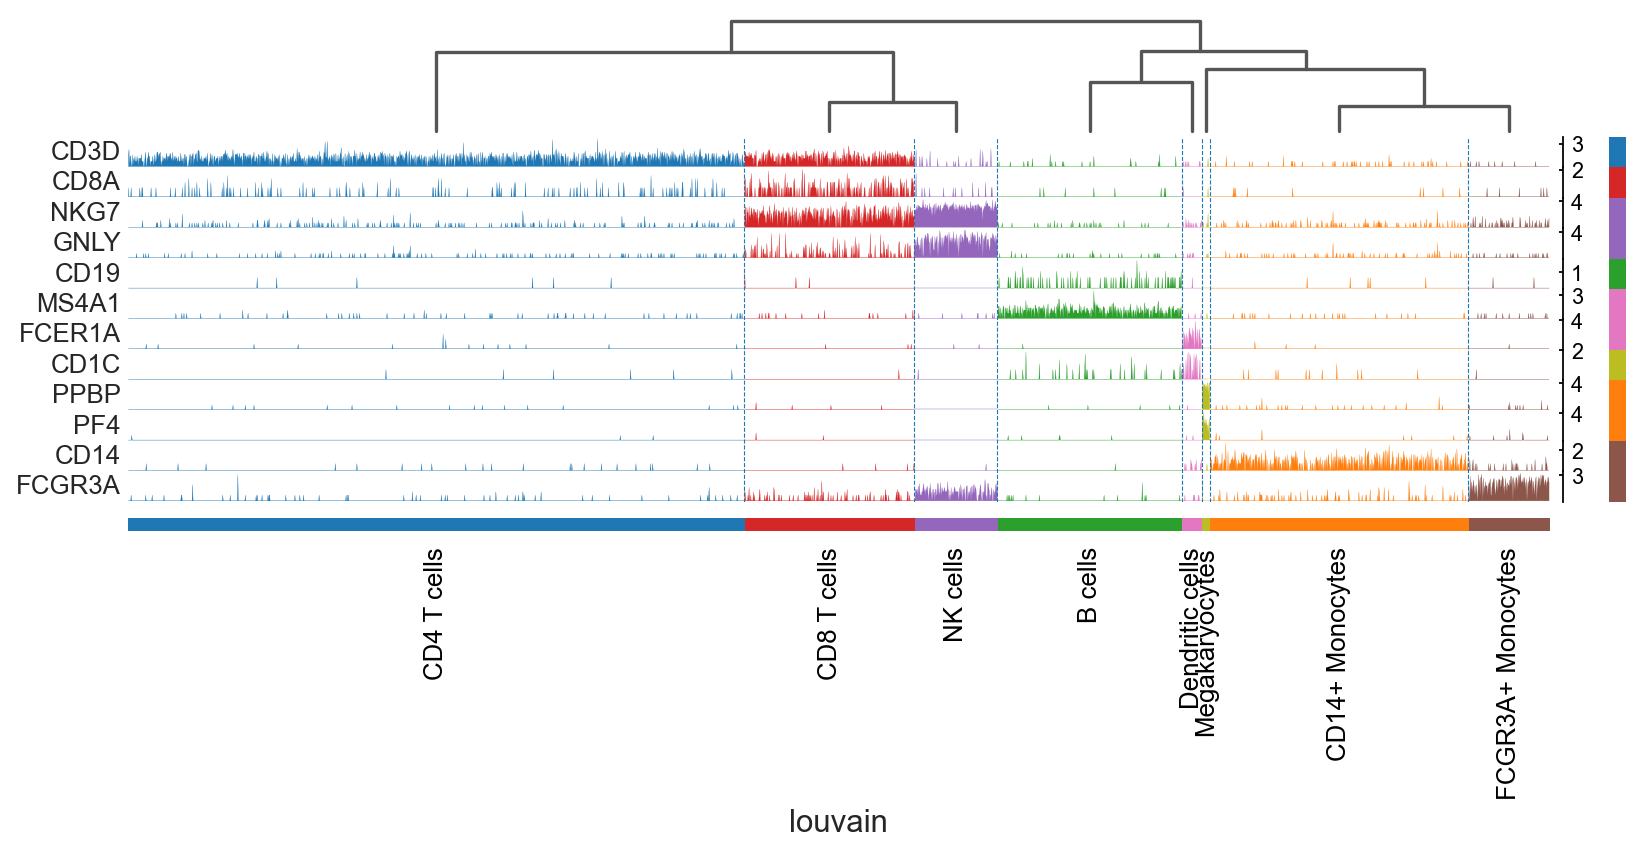

In [60]:
sc.pl.tracksplot(adata, marker_genes_dict, groupby='louvain', dendrogram=True)

#### dendrogram

<AxesSubplot:>

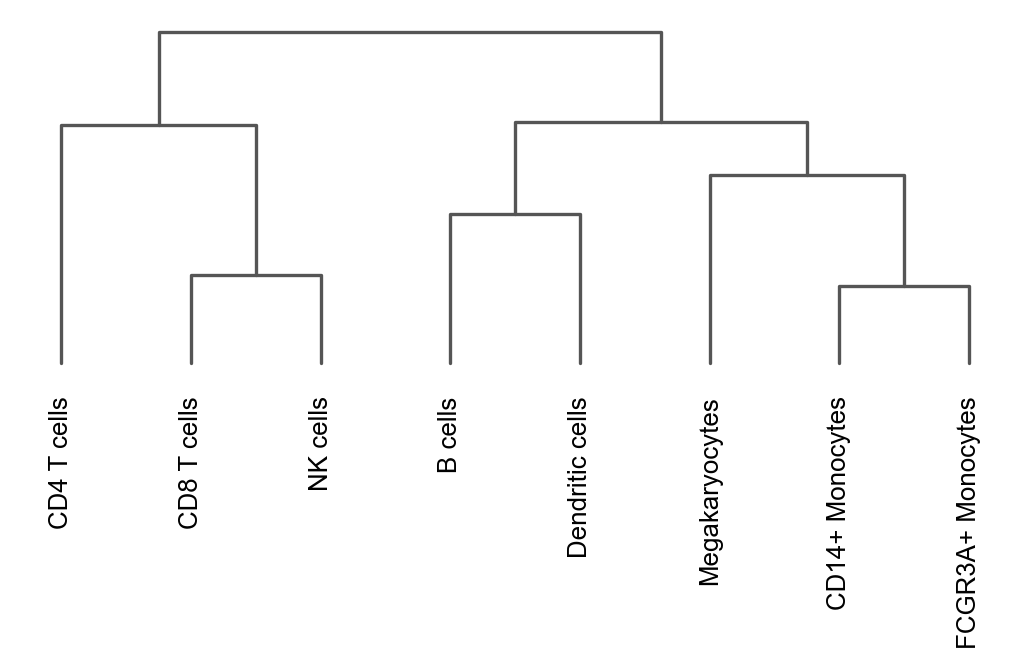

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sc.pl.dendrogram(adata, 'louvain', ax=ax, show=False)

#### Plot correlation

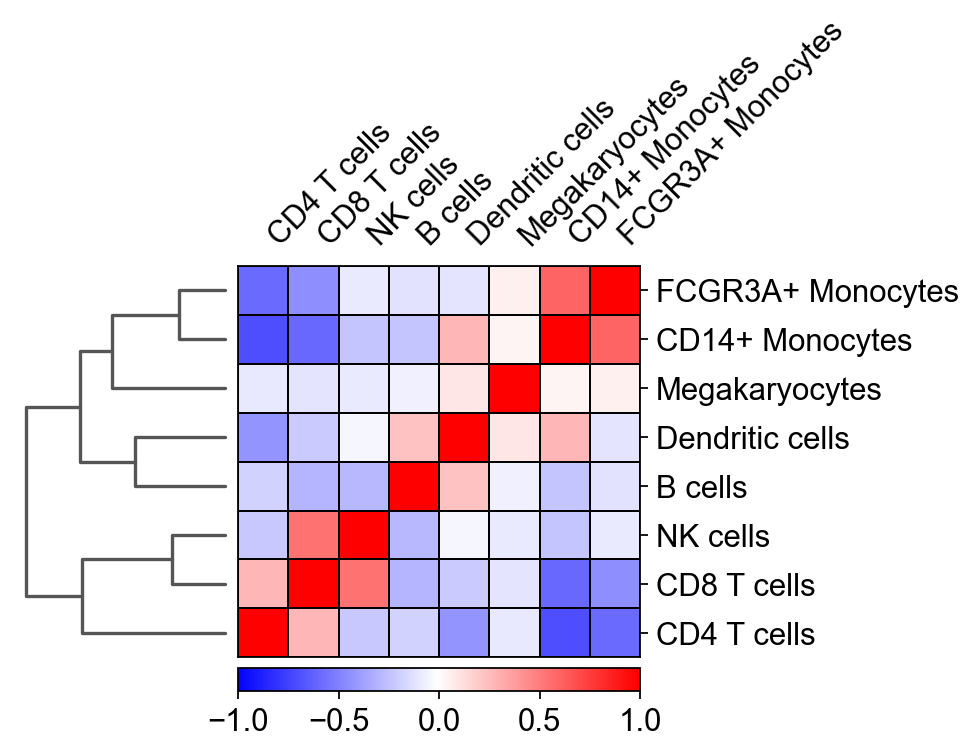

In [62]:
sc.pl.correlation_matrix(adata, 'louvain', figsize=(5,3.5))